In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

# Class dataset

In [2]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torchvision.transforms as transforms

class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32)),  
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        label = int(row[0])
        image = row[1:].astype(np.uint8).reshape(28, 28) 
        image = np.expand_dims(image, axis=2)  
        image = self.transform(image)

        return image, image, label 

# Model Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# 4x4
            nn.ReLU(),
            nn.Flatten(),                                          # 2048
            nn.Linear(2048, 2)                                     # bottleneck
        )

    def forward(self, x):
        return self.encoder(x)

# Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(2, 2048),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

# Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Load dataset

In [6]:

train_dataset = FashionMNISTDataset('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_dataset = FashionMNISTDataset('/kaggle/input/fashionmnist/fashion-mnist_test.csv')


# Persiapan Training

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Saatnya pelatihan Autoencoder

In [8]:

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for imgs, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'model.pth')

Epoch 1: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


Epoch [1/10], Loss: 0.0370


Epoch 2: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]


Epoch [2/10], Loss: 0.0250


Epoch 3: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]


Epoch [3/10], Loss: 0.0235


Epoch 4: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]


Epoch [4/10], Loss: 0.0227


Epoch 5: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]


Epoch [5/10], Loss: 0.0222


Epoch 6: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]


Epoch [6/10], Loss: 0.0217


Epoch 7: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]


Epoch [7/10], Loss: 0.0214


Epoch 8: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]


Epoch [8/10], Loss: 0.0211


Epoch 9: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]


Epoch [9/10], Loss: 0.0209


Epoch 10: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]

Epoch [10/10], Loss: 0.0207


# Contoh visualisasi hasil decode

showing reconstruction: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


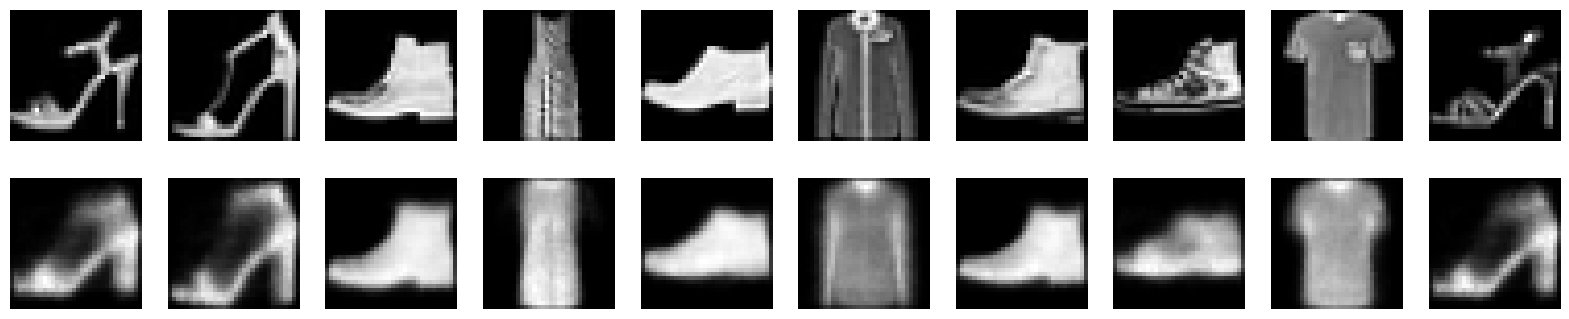

In [9]:
model = Autoencoder().to(device)
model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location=device, weights_only=True))
model.eval()
with torch.no_grad():
    test_imgs, _,_ = next(iter(train_loader))
    test_imgs = test_imgs.to(device)
    outputs = model(test_imgs)

    # Show original and reconstructed
    n = 10
    plt.figure(figsize=(20, 4))
    for i in tqdm(range(n),desc="showing reconstruction"):
        # original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_imgs[i].cpu().squeeze(), cmap='gray')
        ax.axis("off")
        
        # reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
        ax.axis("off")
    plt.show()